In [1]:
! pip install neuraloperator

  Using cached neuraloperator-1.0.2-py3-none-any.whl.metadata (7.5 kB)
  Using cached wandb-0.19.11-py3-none-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached configmypy-0.2.0-py3-none-any.whl.metadata (5.0 kB)
  Using cached tensorly-0.9.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached tensorly_torch-0.5.0-py3-none-any.whl.metadata (4.6 kB)
  Using cached torch_harmonics-0.7.3-py3-none-any.whl
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached pytest-8.3.5-py3-none-any.whl.metadata (7.6 kB)
  Using cached pytest_mock-3.14.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached docker_pycreds-0.4.0-py2.py3-none-any.whl.metadata (1.8 kB)
  Using cached sentry_sdk-2.27.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached setproctitle-1.3.6-cp312-cp312-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (10 kB)
  Using cached iniconfig-2.1.0-py3-none-any.whl.metadata (2.7 kB)
Using cach

In [2]:
from neuralop.data.datasets import DarcyDataset

In [29]:
ds = DarcyDataset(root_dir="./data", n_train= 5000, n_tests= [1000, 500],
                 batch_size = 32, test_batch_sizes = [32, 32],
                 train_resolution= 16,
                 test_resolutions =[16,32],download=True)

Loading test db for resolution 16 with 1000 samples 
Loading test db for resolution 32 with 500 samples 


/srv/conda/envs/notebook/lib/python3.12/site-packages/neuralop/data/datasets/pt_dataset.py:93: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(
/srv/conda/en

In [ ]:
ds1 = DarcyDataset(root_dir="./data", n_train= 1000, n_tests= [100, 50],
                 batch_size = 32, test_batch_sizes = [32, 32],
                 train_resolution= 32,
                 test_resolutions =[16,32],download=True)

In [30]:
a = ds.train_db

In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.fft
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from torch.utils.data import TensorDataset, DataLoader
b = ds.test_dbs[16]
full_loader = DataLoader(b,
                         batch_size=len(b),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
# batch is a dict, so:
x_all_test = batch['x']        # shape [1000, 1, 16, 16]
y_all_test = batch['y']
x_all_test = x_all_test.squeeze(1)  # → [1000, 16, 16]
y_all_test = y_all_test.squeeze(1)
print(x_all_test.shape)        # should print: torch.Size([1000, 16, 16])
print(y_all_test.shape)        # should print: torch.Size([1000, 16, 16])


torch.Size([50, 16, 16])
torch.Size([50, 16, 16])


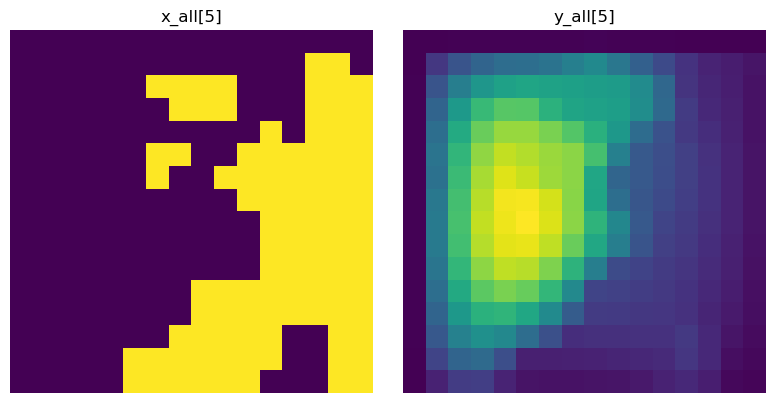

In [34]:
visualize_pair(x_all_test, y_all_test, idx=5)

In [35]:
from torch.utils.data import DataLoader

# a = ds.train_db
full_loader = DataLoader(a,
                         batch_size=len(a),
                         shuffle=False,
                         drop_last=False)

batch = next(iter(full_loader))
# batch is a dict, so:
x_all = batch['x']        # shape [1000, 1, 16, 16]
y_all = batch['y']
x_all = x_all.squeeze(1)  # → [1000, 16, 16]
y_all = y_all.squeeze(1)
print(x_all.shape)        # should print: torch.Size([1000, 16, 16])
print(y_all.shape)        # should print: torch.Size([1000, 16, 16])


torch.Size([1000, 16, 16])
torch.Size([1000, 16, 16])


In [36]:
import matplotlib.pyplot as plt

def visualize_pair(x_all, y_all, idx):
    """
    Plot x_all[idx] and y_all[idx] side by side.

    Parameters
    ----------
    x_all : torch.Tensor or np.ndarray, shape (N, 16, 16)
    y_all : torch.Tensor or np.ndarray, shape (N, 16, 16)
    idx   : int, which sample to plot

    Displays a matplotlib figure.
    """
    # if torch.Tensor, convert to numpy
    if hasattr(x_all, 'cpu'):
        x = x_all[idx].cpu().numpy()
    else:
        x = x_all[idx]
    if hasattr(y_all, 'cpu'):
        y = y_all[idx].cpu().numpy()
    else:
        y = y_all[idx]

    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(x, aspect='equal')
    axes[0].set_title(f'x_all[{idx}]')
    axes[0].axis('off')

    axes[1].imshow(y, aspect='equal')
    axes[1].set_title(f'y_all[{idx}]')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


In [37]:
x_all[5]

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0

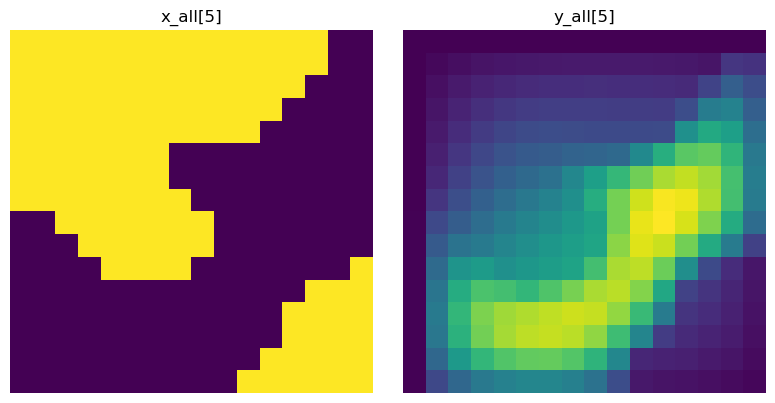

In [14]:
visualize_pair(x_all, y_all, idx=5)

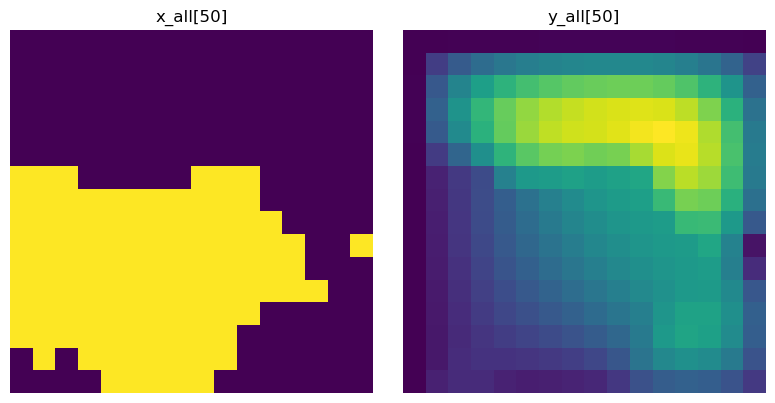

In [26]:
visualize_pair(x_all, y_all, idx=50)

# creating new fft dataset

In [15]:
import torch
import torch.nn.functional as F

def fft_transform(
    x: torch.Tensor,
    target_size=(256,256),
    mode='mag_phase',
    eps=1e-6
) -> torch.Tensor:
    """
    Convert a batch of 2D fields to a 2‑channel frequency‐domain tensor.
    
    Args:
      x             Tensor, shape (B, 1, H, W), values in {0,1} or floats.
      target_size   (h, w) to interpolate to before FFT.
      mode          'mag_phase' or 'real_imag'
      eps           small constant to avoid log(0)
    
    Returns:
      Tensor of shape (B, 2, h, w):
        * if mode=='mag_phase':  channels = [normalized log|FFT|,  phase/π]
        * if mode=='real_imag':  channels = [real(FFT)/M,  imag(FFT)/M]
          where M = global max absolute value in batch so both in [–1,1]
    """
    B, C, H, W = x.shape
    assert C == 1, "expect single‐channel input"
    # 1) Upsample spatially (optional; skip if H,W already target_size)
    x_up = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
    # remove channel for FFT: now (B, h, w)
    x2 = x_up[:, 0]

    # 2) 2D FFT → complex tensor (B, h, w)
    Xf = torch.fft.fft2(x2)

    if mode == 'mag_phase':
        # 3a) magnitude and phase
        mag = torch.abs(Xf)
        # log1p to avoid –inf at zero
        logmag = torch.log1p(mag)
        phase = torch.angle(Xf)  # in [–π, π]

        # 4a) per‐sample normalization to [0, 1]
        # you could also compute global min/max across your TRAINING SET once
        lm = logmag.view(B, -1).min(dim=1)[0].view(B,1,1)
        lM = logmag.view(B, -1).max(dim=1)[0].view(B,1,1)
        mag_n = (logmag - lm) / (lM - lm + eps)

        phase_n = (phase + torch.pi) / (2*torch.pi)  # [0,1]

        out = torch.stack([mag_n, phase_n], dim=1)

    else:
        # 3b) real & imag
        real = Xf.real
        imag = Xf.imag
        # 4b) normalize by a global constant so values ~ in [–1,1]
        M = torch.max(torch.cat([real.abs(), imag.abs()], dim=0))
        out = torch.stack([real/M, imag/M], dim=1)

    return out


In [17]:
import torch
from torch.utils.data import Dataset, DataLoader

class FreqDataset(Dataset):
    """
    Wraps x_all, y_all of shape [N, 16, 16] → returns
    (x_fft, y_fft) each of shape [2, 16, 16].
    """
    def __init__(self,
                 x_all: torch.Tensor,   # [N, 16, 16]
                 y_all: torch.Tensor,   # [N, 16, 16]
                 target_size=(16,16),   # keep 16×16
                 mode='mag_phase'):
        assert x_all.shape == y_all.shape, "x and y must match"
        self.x = x_all.unsqueeze(1).float()  # → [N,1,16,16]
        self.y = y_all.unsqueeze(1).float()
        self.target_size = target_size
        self.mode = mode

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        x = self.x[idx:idx+1]  # [1,1,16,16]
        y = self.y[idx:idx+1]

        # apply the FFT‐based transform you defined
        x_fft = fft_transform(x,
                              target_size=self.target_size,
                              mode=self.mode)
        y_fft = fft_transform(y,
                              target_size=self.target_size,
                              mode=self.mode)
        # each is [1,2,16,16]; drop the sample dim
        return x_fft.squeeze(0), y_fft.squeeze(0)


In [23]:
# say x_all,y_all are torch.Tensor of shape [1000,16,16]
dataset = FreqDataset(x_all, y_all,
                      target_size=(16,16),
                      mode='mag_phase')

loader = DataLoader(dataset,
                    batch_size=32,
                    shuffle=True,
                    drop_last=True)

# check one batch
xb, yb = next(iter(loader))
print(xb.shape, yb.shape)  # -> [32,2,16,16]  [32,2,16,16]

torch.Size([32, 2, 16, 16]) torch.Size([32, 2, 16, 16])


In [24]:
import torch
import torch.nn as nn

class Conv8Net(nn.Module):
    def __init__(self, in_ch=2, out_ch=2, max_ch=128):
        super().__init__()
        # channel progression: 2→32→64→128→64→32→16→2
        self.net = nn.Sequential(
            nn.Conv2d(in_ch,   32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(  32,   64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(  64,  128, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d( 128,   64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(  64,   64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(  64,   32, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(  32,   16, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(  16, out_ch, kernel_size=3, padding=1)
        )
    def forward(self, x):
        """
        x: [B,2,H,W]
        returns: [B,2,H,W]
        """
        return self.net(x)


In [27]:
import torch
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

def train_freq_model(model: nn.Module,
                     dataset: torch.utils.data.Dataset,
                     num_epochs: int = 50,
                     batch_size: int = 32,
                     lr: float = 1e-3,
                     val_split: float = 0.1,
                     device: str = "cuda" if torch.cuda.is_available() else "cpu"):
    # Split train/val
    N = len(dataset)
    n_val = int(N * val_split)
    n_train = N - n_val
    train_ds, val_ds = random_split(dataset, [n_train, n_val])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)

    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    best_val = float('inf')
    best_state = None

    for epoch in range(1, num_epochs+1):
        # ——— Training ———
        model.train()
        train_bar = tqdm(train_loader, desc=f"Epoch {epoch}/{num_epochs} [Train]", leave=False)
        train_loss = 0.0
        for i, (x_fft, y_fft) in enumerate(train_bar):
            x_fft, y_fft = x_fft.to(device), y_fft.to(device)
            optimizer.zero_grad()
            y_pred = model(x_fft)
            loss = criterion(y_pred, y_fft)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            avg_train = train_loss / (i + 1)
            train_bar.set_postfix(loss=f"{avg_train:.4f}")

        # ——— Validation ———
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x_fft, y_fft in val_loader:
                x_fft, y_fft = x_fft.to(device), y_fft.to(device)
                y_pred = model(x_fft)
                val_loss += criterion(y_pred, y_fft).item()
        avg_val = val_loss / max(len(val_loader), 1)

        print(
            f"Epoch {epoch}/{num_epochs}  "
            f"Train Loss={train_loss/len(train_loader):.6f}  "
            f"Val   Loss={avg_val:.6f}"
        )

        if avg_val < best_val:
            best_val = avg_val
            best_state = model.state_dict()
            print(f" → New best model (Val Loss={best_val:.6f})")

    # load best weights & return on CPU
    if best_state is not None:
        model.load_state_dict(best_state)
    return model.to("cpu")


In [42]:
model   = Conv8Net(in_ch=2, out_ch=2)

best_model = train_freq_model(
    model,
    dataset,
    num_epochs=100,
    batch_size=32,
    lr=1e-3,
    val_split=0.1
)

Epoch 1/100  Train Loss=0.119335  Val   Loss=0.070400
 → New best model (Val Loss=0.070400)


Epoch 2/100  Train Loss=0.059052  Val   Loss=0.050967
 → New best model (Val Loss=0.050967)


Epoch 3/100  Train Loss=0.045218  Val   Loss=0.042637
 → New best model (Val Loss=0.042637)


Epoch 4/100  Train Loss=0.040812  Val   Loss=0.040249
 → New best model (Val Loss=0.040249)


Epoch 5/100  Train Loss=0.038959  Val   Loss=0.038759
 → New best model (Val Loss=0.038759)


Epoch 6/100  Train Loss=0.037920  Val   Loss=0.038095
 → New best model (Val Loss=0.038095)


Epoch 7/100  Train Loss=0.037473  Val   Loss=0.037778
 → New best model (Val Loss=0.037778)


Epoch 8/100  Train Loss=0.037275  Val   Loss=0.037633
 → New best model (Val Loss=0.037633)


Epoch 9/100  Train Loss=0.037090  Val   Loss=0.037476
 → New best model (Val Loss=0.037476)


Epoch 10/100  Train Loss=0.036926  Val   Loss=0.037296
 → New best model (Val Loss=0.037296)


Epoch 11/100  Train Loss=0.036819  Val   Loss=0.037159
 → New best model (Val Loss=0.037159)


Epoch 12/100  Train Loss=0.036684  Val   Loss=0.037080
 → New best model (Val Loss=0.037080)


Epoch 13/100  Train Loss=0.036543  Val   Loss=0.036933
 → New best model (Val Loss=0.036933)


Epoch 14/100  Train Loss=0.036465  Val   Loss=0.036871
 → New best model (Val Loss=0.036871)


Epoch 15/100  Train Loss=0.036377  Val   Loss=0.036653
 → New best model (Val Loss=0.036653)


Epoch 16/100  Train Loss=0.036287  Val   Loss=0.036635
 → New best model (Val Loss=0.036635)


Epoch 17/100  Train Loss=0.036245  Val   Loss=0.036646


Epoch 18/100  Train Loss=0.036198  Val   Loss=0.036647


Epoch 19/100  Train Loss=0.036184  Val   Loss=0.036594
 → New best model (Val Loss=0.036594)


Epoch 20/100  Train Loss=0.036071  Val   Loss=0.036466
 → New best model (Val Loss=0.036466)


Epoch 21/100  Train Loss=0.036037  Val   Loss=0.036444
 → New best model (Val Loss=0.036444)


Epoch 22/100  Train Loss=0.035990  Val   Loss=0.036512


Epoch 23/100  Train Loss=0.035967  Val   Loss=0.036392
 → New best model (Val Loss=0.036392)


Epoch 24/100  Train Loss=0.035918  Val   Loss=0.036334
 → New best model (Val Loss=0.036334)


Epoch 25/100  Train Loss=0.035902  Val   Loss=0.036295
 → New best model (Val Loss=0.036295)


Epoch 26/100  Train Loss=0.035850  Val   Loss=0.036293
 → New best model (Val Loss=0.036293)


Epoch 27/100  Train Loss=0.035820  Val   Loss=0.036308


Epoch 28/100  Train Loss=0.035761  Val   Loss=0.036281
 → New best model (Val Loss=0.036281)


Epoch 29/100  Train Loss=0.035757  Val   Loss=0.036271
 → New best model (Val Loss=0.036271)


Epoch 30/100  Train Loss=0.035728  Val   Loss=0.036360


Epoch 31/100  Train Loss=0.035703  Val   Loss=0.036208
 → New best model (Val Loss=0.036208)


Epoch 32/100  Train Loss=0.035610  Val   Loss=0.036173
 → New best model (Val Loss=0.036173)


Epoch 33/100  Train Loss=0.035554  Val   Loss=0.036162
 → New best model (Val Loss=0.036162)


Epoch 34/100  Train Loss=0.035510  Val   Loss=0.036186


Epoch 35/100  Train Loss=0.035470  Val   Loss=0.036138
 → New best model (Val Loss=0.036138)


Epoch 36/100  Train Loss=0.035358  Val   Loss=0.035982
 → New best model (Val Loss=0.035982)


Epoch 37/100  Train Loss=0.035326  Val   Loss=0.036063


Epoch 38/100  Train Loss=0.035338  Val   Loss=0.036143


Epoch 39/100  Train Loss=0.035243  Val   Loss=0.035973
 → New best model (Val Loss=0.035973)


Epoch 40/100  Train Loss=0.035159  Val   Loss=0.035939
 → New best model (Val Loss=0.035939)


Epoch 41/100  Train Loss=0.035096  Val   Loss=0.035979


Epoch 42/100  Train Loss=0.035023  Val   Loss=0.035881
 → New best model (Val Loss=0.035881)


Epoch 43/100  Train Loss=0.034981  Val   Loss=0.036157


Epoch 44/100  Train Loss=0.034893  Val   Loss=0.035967


Epoch 45/100  Train Loss=0.034813  Val   Loss=0.035845
 → New best model (Val Loss=0.035845)


Epoch 46/100  Train Loss=0.034781  Val   Loss=0.035962


Epoch 47/100  Train Loss=0.034687  Val   Loss=0.035738
 → New best model (Val Loss=0.035738)


Epoch 48/100  Train Loss=0.034644  Val   Loss=0.035689
 → New best model (Val Loss=0.035689)


Epoch 49/100  Train Loss=0.034540  Val   Loss=0.035596
 → New best model (Val Loss=0.035596)


Epoch 50/100  Train Loss=0.034420  Val   Loss=0.035642


Epoch 51/100  Train Loss=0.034425  Val   Loss=0.035737


Epoch 52/100  Train Loss=0.034281  Val   Loss=0.035682


Epoch 53/100  Train Loss=0.034234  Val   Loss=0.035600


Epoch 54/100  Train Loss=0.034118  Val   Loss=0.035669


Epoch 55/100  Train Loss=0.034059  Val   Loss=0.035740


Epoch 56/100  Train Loss=0.033981  Val   Loss=0.035635


Epoch 57/100  Train Loss=0.033942  Val   Loss=0.035521
 → New best model (Val Loss=0.035521)


Epoch 58/100  Train Loss=0.033808  Val   Loss=0.035673


Epoch 59/100  Train Loss=0.033796  Val   Loss=0.035730


Epoch 60/100  Train Loss=0.033667  Val   Loss=0.035379
 → New best model (Val Loss=0.035379)


Epoch 61/100  Train Loss=0.033542  Val   Loss=0.035411


Epoch 62/100  Train Loss=0.033450  Val   Loss=0.035566


Epoch 63/100  Train Loss=0.033379  Val   Loss=0.035201
 → New best model (Val Loss=0.035201)


Epoch 64/100  Train Loss=0.033277  Val   Loss=0.035292


Epoch 65/100  Train Loss=0.033192  Val   Loss=0.035219


Epoch 66/100  Train Loss=0.033125  Val   Loss=0.035228


Epoch 67/100  Train Loss=0.033033  Val   Loss=0.035346


Epoch 68/100  Train Loss=0.032979  Val   Loss=0.035189
 → New best model (Val Loss=0.035189)


Epoch 69/100  Train Loss=0.032884  Val   Loss=0.035183
 → New best model (Val Loss=0.035183)


Epoch 70/100  Train Loss=0.032776  Val   Loss=0.035176
 → New best model (Val Loss=0.035176)


Epoch 71/100  Train Loss=0.032771  Val   Loss=0.035430


Epoch 72/100  Train Loss=0.032653  Val   Loss=0.035323


Epoch 73/100  Train Loss=0.032499  Val   Loss=0.035446


Epoch 74/100  Train Loss=0.032443  Val   Loss=0.035245


Epoch 75/100  Train Loss=0.032261  Val   Loss=0.035424


Epoch 76/100  Train Loss=0.032231  Val   Loss=0.035097
 → New best model (Val Loss=0.035097)


Epoch 77/100  Train Loss=0.032108  Val   Loss=0.035382


Epoch 78/100  Train Loss=0.032101  Val   Loss=0.035185


Epoch 79/100  Train Loss=0.031894  Val   Loss=0.035386


Epoch 80/100  Train Loss=0.031808  Val   Loss=0.035540


Epoch 81/100  Train Loss=0.031691  Val   Loss=0.035595


Epoch 82/100  Train Loss=0.031724  Val   Loss=0.035481


Epoch 83/100  Train Loss=0.031535  Val   Loss=0.035502


Epoch 84/100  Train Loss=0.031460  Val   Loss=0.035663


Epoch 85/100  Train Loss=0.031401  Val   Loss=0.035654


Epoch 86/100  Train Loss=0.031239  Val   Loss=0.035827


Epoch 87/100  Train Loss=0.031143  Val   Loss=0.035915


Epoch 88/100  Train Loss=0.031147  Val   Loss=0.036049


Epoch 89/100  Train Loss=0.031060  Val   Loss=0.036019


Epoch 90/100  Train Loss=0.030997  Val   Loss=0.035949


Epoch 91/100  Train Loss=0.030851  Val   Loss=0.035672


Epoch 92/100  Train Loss=0.030695  Val   Loss=0.036049


Epoch 93/100  Train Loss=0.030699  Val   Loss=0.036217


Epoch 94/100  Train Loss=0.030625  Val   Loss=0.035868


Epoch 95/100  Train Loss=0.030341  Val   Loss=0.036191


Epoch 96/100  Train Loss=0.030263  Val   Loss=0.036422


Epoch 97/100  Train Loss=0.030161  Val   Loss=0.036509


Epoch 98/100  Train Loss=0.030232  Val   Loss=0.036405


Epoch 99/100  Train Loss=0.030014  Val   Loss=0.036333


Epoch 100/100  Train Loss=0.029908  Val   Loss=0.036367


In [45]:
import torch
import random
import matplotlib.pyplot as plt

device = "cpu"

def run_and_plot(x_raw, y_raw, model, title):
    """
    x_raw, y_raw: torch.Tensor shape [16,16]
    model: CPU model that maps fft→fft
    """
    # 1) Prepare batch dims & channels
    x = x_raw.unsqueeze(0).unsqueeze(0)  # [1,1,16,16]
    y = y_raw.unsqueeze(0).unsqueeze(0)

    # 2) FFT‐transform
    x_fft = fft_transform(x, target_size=(16,16), mode='mag_phase')  # [1,2,16,16]
    # 3) Predict in freq‐domain
    with torch.no_grad():
        y_pred_fft = model(x_fft)  # [1,2,16,16]
    y_pred_fft = y_pred_fft.squeeze(0)
    print(y_pred_fft.shape)
    # 4) Inverse‐transform
    y_rec = inverse_fft_transform(y_pred_fft, y_raw)  # [1,16,16]
    y_rec = y_rec.squeeze(0)                   # [16,16]

    # 5) Plot
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(x_raw.numpy(), cmap='viridis'); axs[0].set_title(f"{title}: input x")
    axs[1].imshow(y_raw.numpy(), cmap='viridis'); axs[1].set_title(f"{title}: true y")
    axs[2].imshow(y_rec.numpy(), cmap='viridis'); axs[2].set_title(f"{title}: recon y")
    for ax in axs: ax.axis('off')
    plt.tight_layout()
    plt.show()




In [43]:
import torch

def inverse_fft_transform(norm_fft: torch.Tensor,
                          raw: torch.Tensor,
                          eps: float = 1e-8) -> torch.Tensor:
    """
    Invert the mag–phase normalization back to a real image.

    Args:
      norm_fft:    Tensor of shape [2, H, W], channels = [norm_log_mag, norm_phase]
      raw:         Tensor of shape [H, W] (the original spatial image)
      eps:         small constant

    Returns:
      recov:       Tensor of shape [H, W], the reconstructed real‐space field
    """
    # 1) Recompute L_min, L_max on the original
    Xf_orig = torch.fft.fft2(raw)
    mag_orig = torch.abs(Xf_orig)
    logmag   = torch.log(mag_orig + eps)
    L_min    = logmag.min()
    L_max    = logmag.max()

    # 2) Split the two channels
    norm_log_mag = norm_fft[0]   # shape [H,W]
    norm_phase   = norm_fft[1]   # shape [H,W]

    # 3) Reverse normalization on log-magnitude
    recov_log_mag = norm_log_mag * (L_max - L_min) + L_min
    recov_mag     = torch.exp(recov_log_mag) - eps

    # 4) Reverse normalization on phase
    recov_phase   = norm_phase * (2 * torch.pi) - torch.pi

    # 5) Reconstruct complex spectrum and IFFT
    real_part = recov_mag * torch.cos(recov_phase)
    imag_part = recov_mag * torch.sin(recov_phase)
    Xf_rec    = torch.complex(real_part, imag_part)
    recov     = torch.fft.ifft2(Xf_rec).real

    return recov


torch.Size([2, 16, 16])


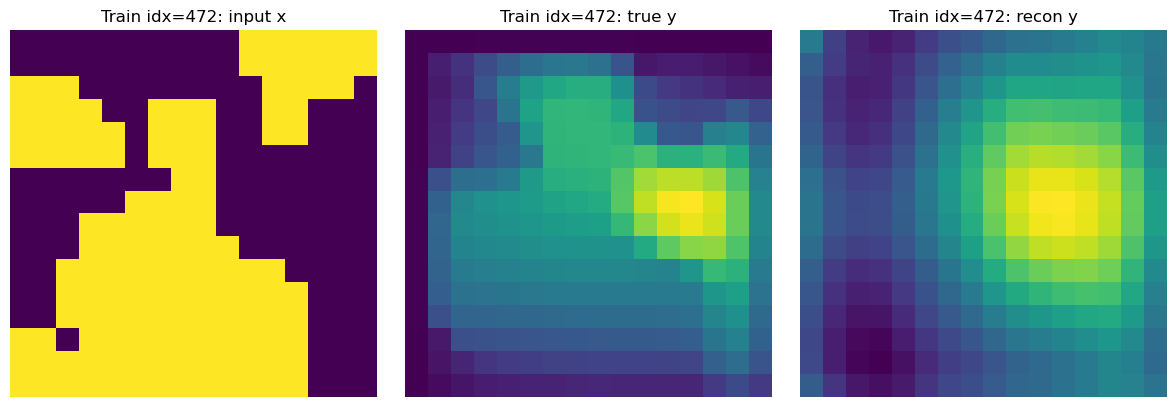

torch.Size([2, 16, 16])


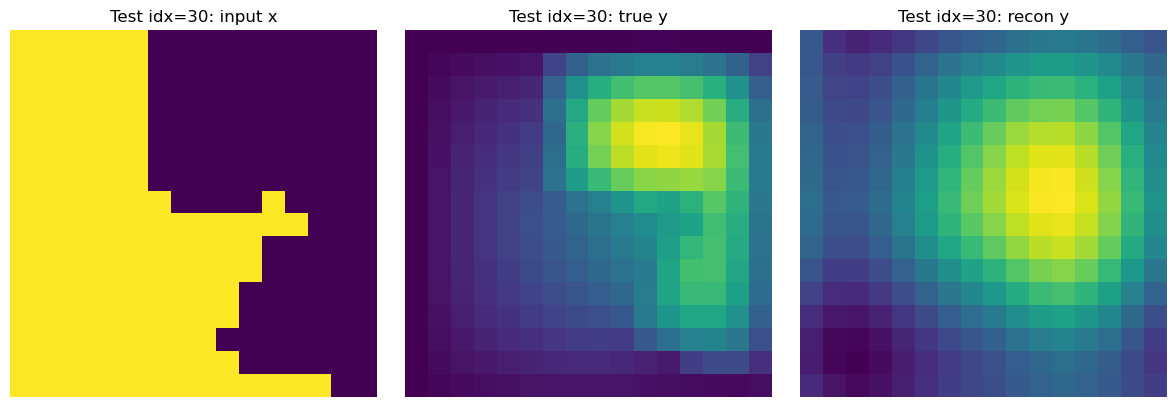

In [48]:
# Pick random train index
idx_train = random.randrange(x_all.shape[0])
run_and_plot(x_all[idx_train], y_all[idx_train], best_model, f"Train idx={idx_train}")

# Pick random test index
idx_test = random.randrange(x_all_test.shape[0])
run_and_plot(x_all_test[idx_test], y_all_test[idx_test], best_model, f"Test idx={idx_test}")